<a href="https://colab.research.google.com/github/mchirico/COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID-19**

Note:  You need to make a copy of this note book, if you want to run it yourself
by clicking on "File/Save a copy in Drive"



Sharable link:
https://drive.google.com/file/d/1_aZIvr3QWWSbU_DNWEz-E4yDLVR6Emgd/view?usp=sharing








[Google Maps of Accidents](https://storage.googleapis.com/montco-stats/vehicleAccident.html)



In [0]:
import requests
import pandas as pd
import numpy as np 
from datetime import datetime



import warnings
warnings.filterwarnings("ignore")

try:
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive
  import torch
except:
  print("Will try to install software")
  # Lines below .... Only need to be run once at the top of the notebook.
  !pip install -q matplotlib-venn
  !pip install -q keras
  # #   https://pypi.python.org/pypi/pydot
  !apt-get -qq install -y graphviz && pip install -q pydot
  !apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
  !pip install -U -q PyDrive
  !pip install --upgrade -q gspread
  
  !pip install torchvision
  
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive





## Reading in the data..

In [3]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
d=pd.read_csv(url)
d.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414,414,418,418,422
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,102,119


In [68]:
m=pd.melt(d, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
m.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
m['timeStamp'] = m['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
m.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,Anhui,Mainland China,31.8257,117.2264,2020-01-22,1
1,Beijing,Mainland China,40.1824,116.4142,2020-01-22,14
2,Chongqing,Mainland China,30.0572,107.8740,2020-01-22,6
3,Fujian,Mainland China,26.0789,117.9874,2020-01-22,1
4,Gansu,Mainland China,36.0611,103.8343,2020-01-22,0


In [69]:
n=pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns=pd.pivot_table(m, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns = ns.diff(axis=1)
ns=ns.reset_index()

n.head()

,,,timeStamp,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06
Province/State,Country/Region,Lat,Long,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Montreal, QC",Canada,45.5017,-73.5673,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2
"Norfolk County, MA",US,42.1767,-71.1449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2
Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990,990,990,990,990
Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414,414,418,418,422
"Bergen County, NJ",US,40.9263,-74.0770,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [70]:

ns.head()

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00
0,Afghanistan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Algeria,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,0.0,5.0
2,Andorra,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Argentina,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,Armenia,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [71]:
ns[ns['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00
94,US,NaN,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,18.0,0.0,6.0,1.0,2.0,8.0,6.0,25.0,21.0,31.0,68.0,57.0


In [77]:
nm=pd.melt(ns, id_vars=['Country/Region'], value_vars=ns.columns[1::])
nm.head(7)

,Country/Region,timeStamp,value
0,Afghanistan,2020-01-22,NaN
1,Algeria,2020-01-22,NaN
2,Andorra,2020-01-22,NaN
3,Argentina,2020-01-22,NaN
4,Armenia,2020-01-22,NaN
5,Australia,2020-01-22,NaN
6,Austria,2020-01-22,NaN


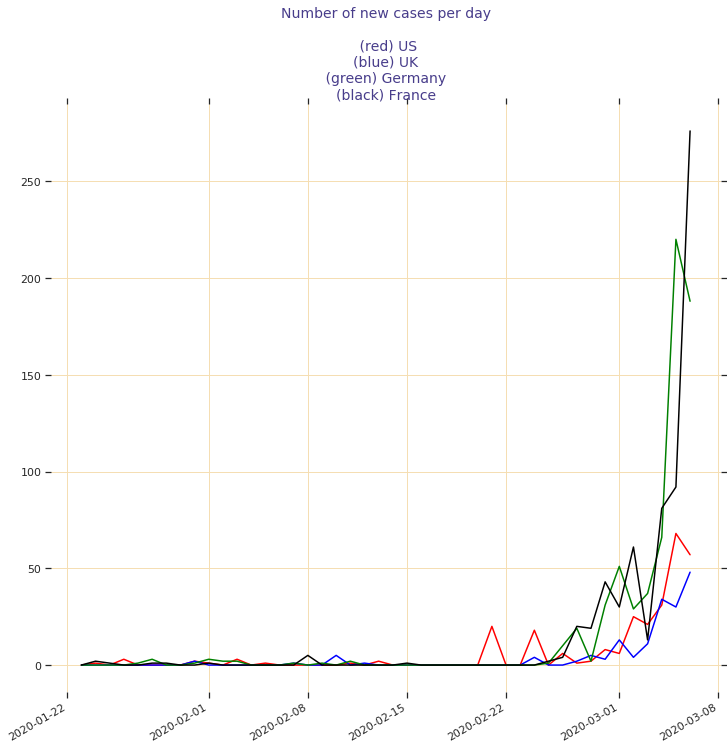

In [92]:

t=nm[nm['Country/Region']=='US']
t2=nm[nm['Country/Region']=='UK']
t3=nm[nm['Country/Region']=='Germany']
t4=nm[nm['Country/Region']=='France']



from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12,12))



ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


ax.plot(t['timeStamp'],t['value'],color = 'red')
ax.plot(t2['timeStamp'],t2['value'],color = 'blue')
ax.plot(t3['timeStamp'],t3['value'],color = 'green')
ax.plot(t3['timeStamp'],t4['value'],color = 'black')


ax.set_title("""Number of new cases per day
\n (red) US\n(blue) UK\n (green) Germany \n(black) France""", 
             fontsize=14, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

,lat,lng,desc,zip,title,timeStamp,twp,e
582370,40.2309343,-75.5221245,LIGHTCAP RD & SANATOGA SPRINGS DR; LIMERICK; 2...,19468,Fire: FIRE ALARM,2019-12-01 20:47:01,LIMERICK,1
582369,40.2750300,-75.4298706,GRUBB RD & LARSON RD; UPPER SALFORD; 2019-12-0...,19473,Traffic: VEHICLE ACCIDENT -,2019-12-01 20:37:00,UPPER SALFORD,1
582368,40.2316017,-75.2186547,HORSHAM RD & PHEASANT RUN; MONTGOMERY; Statio...,18936,EMS: RESPIRATORY EMERGENCY,2019-12-01 20:17:01,MONTGOMERY,1
582367,40.2726648,-75.2622256,KAROL WAY & SHARON RD; HATFIELD TOWNSHIP; Sta...,18915,EMS: FALL VICTIM,2019-12-01 20:17:01,HATFIELD TOWNSHIP,1
582366,40.2703902,-75.3738837,SHIRLEY DR & FLORENCE DR; LOWER SALFORD; Stat...,19438,EMS: FALL VICTIM,2019-12-01 20:17:00,LOWER SALFORD,1


In [0]:
# Use a temp table (t)


t=d[d['timeStamp']>= '2015-01-01']

# Use for easy totals
t['e']=1
p = pd.pivot_table(t, values='e', index=['timeStamp'], columns=['title'], aggfunc=np.sum)


# 1 hour intervals
pp = p.resample('1h').apply(np.sum).reset_index()


pp.columns = pp.columns.get_level_values(0)

pp.fillna(0, inplace=True)
pp.sort_values(by=['timeStamp'], ascending=False, inplace=True)
pp[['timeStamp','Traffic: VEHICLE ACCIDENT -','Traffic: DISABLED VEHICLE -','Traffic: HAZARDOUS ROAD CONDITIONS -','EMS: VEHICLE ACCIDENT']].head(9)


title,timeStamp,Traffic: VEHICLE ACCIDENT -,Traffic: DISABLED VEHICLE -,Traffic: HAZARDOUS ROAD CONDITIONS -,EMS: VEHICLE ACCIDENT
34851,2019-12-01 20:00:00,2.0,0.0,0.0,0.0
34850,2019-12-01 19:00:00,8.0,3.0,0.0,0.0
34849,2019-12-01 18:00:00,3.0,2.0,0.0,0.0
34848,2019-12-01 17:00:00,2.0,2.0,0.0,0.0
34847,2019-12-01 16:00:00,9.0,3.0,1.0,0.0
34846,2019-12-01 15:00:00,2.0,0.0,0.0,0.0
34845,2019-12-01 14:00:00,2.0,2.0,0.0,0.0
34844,2019-12-01 13:00:00,8.0,0.0,0.0,0.0
34843,2019-12-01 12:00:00,3.0,0.0,0.0,0.0


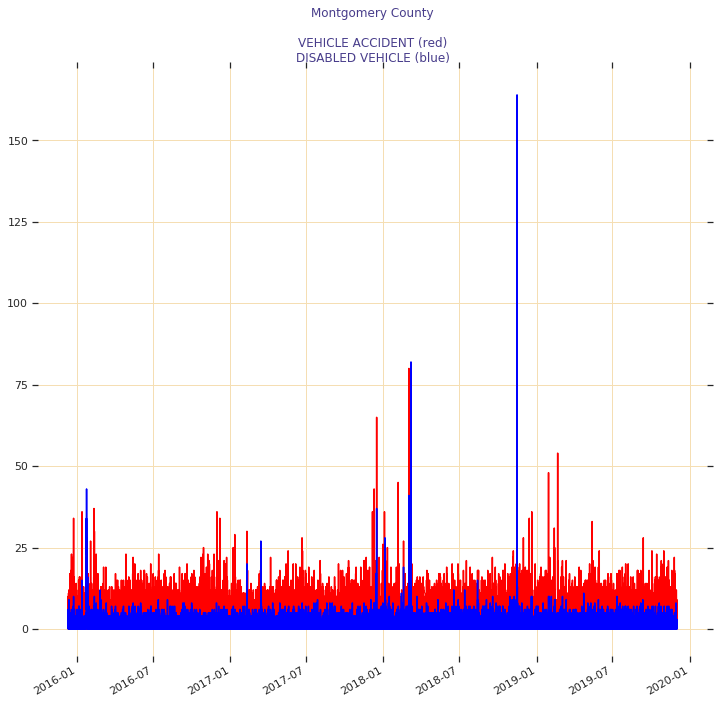

In [0]:


t=pp[pp['timeStamp']>= '2015-03-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12,12))



ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['Traffic: DISABLED VEHICLE -'],color = 'blue')

ax.set_title("Montgomery County\n\nVEHICLE ACCIDENT (red)\nDISABLED VEHICLE (blue)", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()


**CARDIAC ARREST**


In [0]:
# Use a temp table (t)


t=d[d['timeStamp']>= '2015-01-01']

# Use for easy totals
t['e']=1
p = pd.pivot_table(t, values='e', index=['timeStamp'], columns=['title'], aggfunc=np.sum)


# 1 hour intervals
pp = p.resample('6h').apply(np.sum).reset_index()


pp.columns = pp.columns.get_level_values(0)

pp.fillna(0, inplace=True)
pp.sort_values(by=['timeStamp'], ascending=False, inplace=True)
pp[['timeStamp','EMS: CARDIAC ARREST','EMS: FALL VICTIM','Traffic: VEHICLE ACCIDENT -','EMS: VEHICLE ACCIDENT']].head(10)


title,timeStamp,EMS: CARDIAC ARREST,EMS: FALL VICTIM,Traffic: VEHICLE ACCIDENT -,EMS: VEHICLE ACCIDENT
3331,2018-03-22 06:00:00,0.0,2.0,15.0,0.0
3330,2018-03-22 00:00:00,0.0,6.0,7.0,1.0
3329,2018-03-21 18:00:00,0.0,7.0,23.0,0.0
3328,2018-03-21 12:00:00,6.0,6.0,62.0,6.0
3327,2018-03-21 06:00:00,2.0,1.0,51.0,13.0
3326,2018-03-21 00:00:00,0.0,2.0,3.0,1.0
3325,2018-03-20 18:00:00,2.0,2.0,53.0,15.0
3324,2018-03-20 12:00:00,0.0,7.0,54.0,8.0
3323,2018-03-20 06:00:00,2.0,7.0,15.0,4.0
3322,2018-03-20 00:00:00,1.0,2.0,0.0,0.0


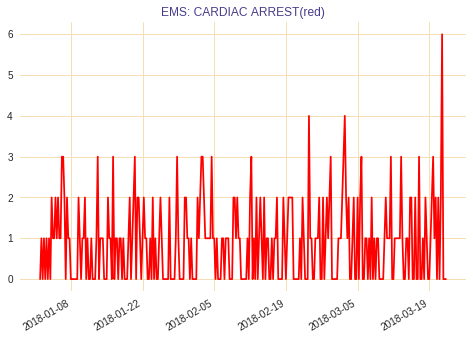

In [0]:
t=pp[pp['timeStamp']>= '2018-01-02']


from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


#ax.plot(t['timeStamp'],t['Traffic: VEHICLE ACCIDENT -'],color = 'red')
ax.plot(t['timeStamp'],t['EMS: CARDIAC ARREST'],color = 'red')

ax.set_title("EMS: CARDIAC ARREST(red)", 
             fontsize=12, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()